In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import plotly.express as px
import plotly.io as pio
import seaborn as sns

from pathlib import Path
import pandas as pd
import numpy as np
import itertools

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

pio.renderers.default = "iframe"

In [2]:
def fix_up_df(df: pd.DataFrame):
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["removals"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
    return df

In [3]:
def plot_n_ad_and_ir_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id]
    df.head()
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(121)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='red', label="Information Remaining")
    ax1.set_ylabel("Information Remaining")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, df.areal_density, color="blue", label="Areal Density")
    ax2.set_ylabel("Areal Density")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=4)
    
    ax1.set_title(f"Simulation {simulation_id}")


    ax1 = fig.add_subplot(122)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='red', label="Information Remaining")
    ax1.set_ylabel("Information Remaining")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, df.n_craters_in_study_region, color="blue", label="N Craters Remaining")
    ax2.set_ylabel("Areal Density")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=4)
    
    ax1.set_title(f"Simulation {simulation_id}")
    plt.show()

In [4]:
base_path = "/data/saturation/n_craters_stop_condition_20230918/"

ivs = [
    "slope",
    "effective_radius_multiplier",
    "r_stat_multiplier",
    "min_rim_percentage",
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "n_craters_in_study_region",
    "radius_mean",
    "radius_stdev"
]

non_constant_ivs = [
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "n_craters_in_study_region",
    "radius_mean",
    "radius_stdev"
]

iv_labels = {
    "slope": "$b$",
    "effective_radius_multiplier": "$E_{mult}$",
    "r_stat_multiplier": "$E_{ratio}$",
    "min_rim_percentage": "$M_r$",
    "n_craters_in_study_region": "$N_S$",
    "areal_density": "Median $A_d$",
    "information_remaining": "Information Remaining",
}

In [5]:
stats_df = pd.read_parquet(f"{base_path}/train_500_100.parquet").sort_values("crater_id")
stats_df = fix_up_df(stats_df)

test_df = pd.read_parquet(f"{base_path}/train_500_100.parquet").sort_values("crater_id")
test_df = fix_up_df(test_df)

simulation_ids = stats_df.simulation_id.unique()

### Visualizing Information Remaining for a few simulations

It appears that around IR in (0.4, 0.6), saturation is reached according to AD and N.

n = number of craters observable on the surface at present

N = number of craters ever to impact surface

IR = n / N

slope                          1.109352
effective_radius_multiplier    1.718567
r_stat_multiplier              5.253837
min_rim_percentage             0.287268
Name: 18918, dtype: float64


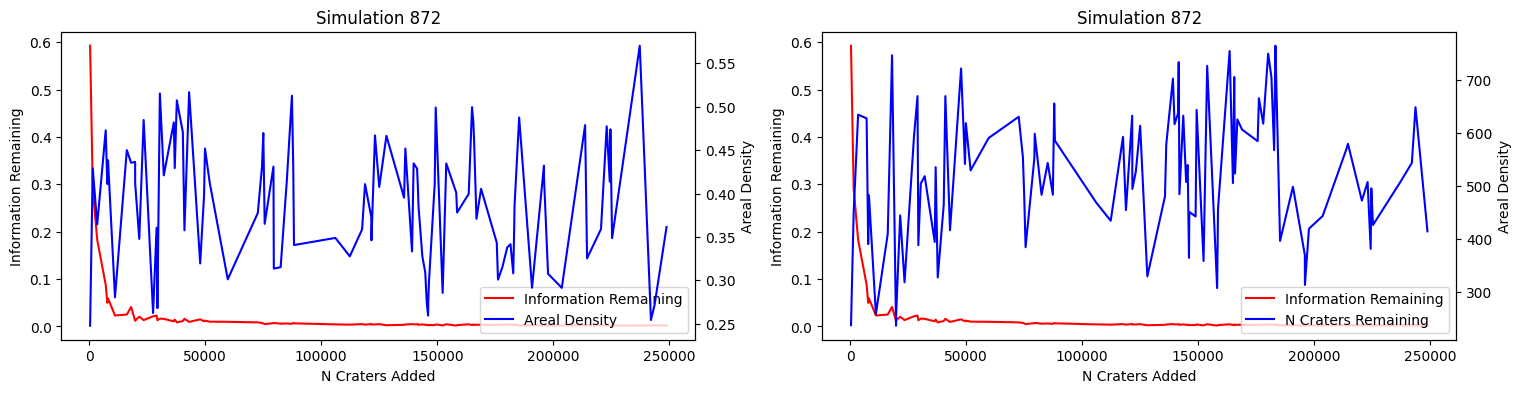

slope                          1.492005
effective_radius_multiplier    1.416901
r_stat_multiplier              4.287691
min_rim_percentage             0.641115
Name: 34450, dtype: float64


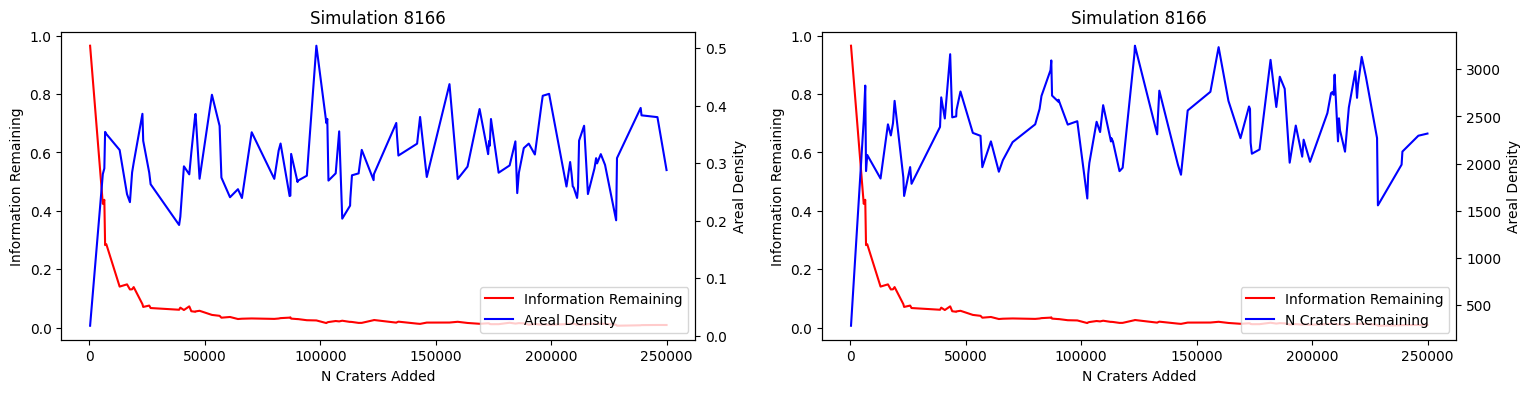

slope                          1.337579
effective_radius_multiplier    1.188402
r_stat_multiplier              3.063083
min_rim_percentage             0.311337
Name: 17166, dtype: float64


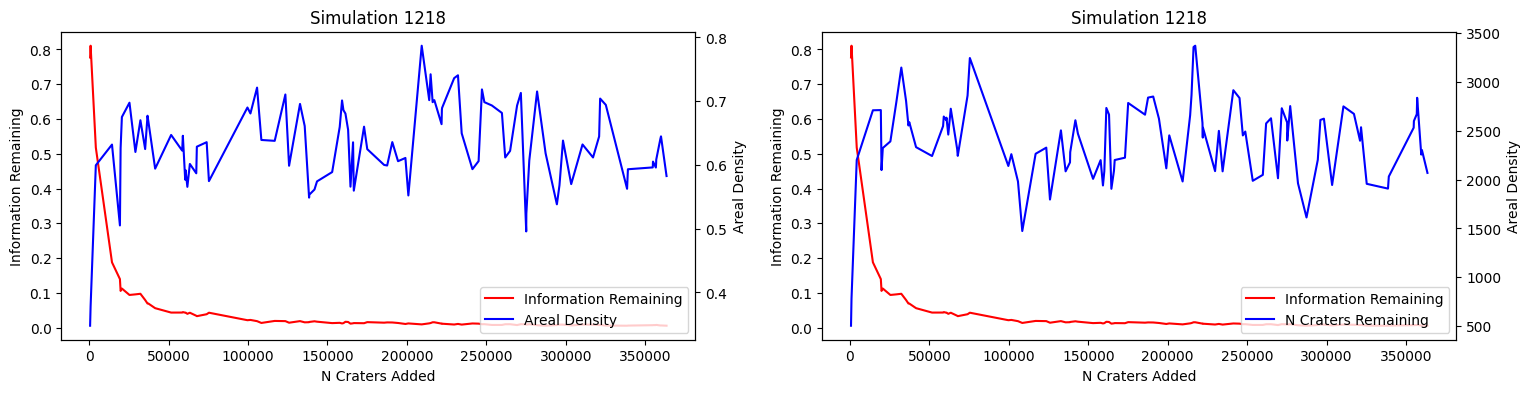

slope                          1.448572
effective_radius_multiplier    1.851666
r_stat_multiplier              5.329822
min_rim_percentage             0.617149
Name: 29477, dtype: float64


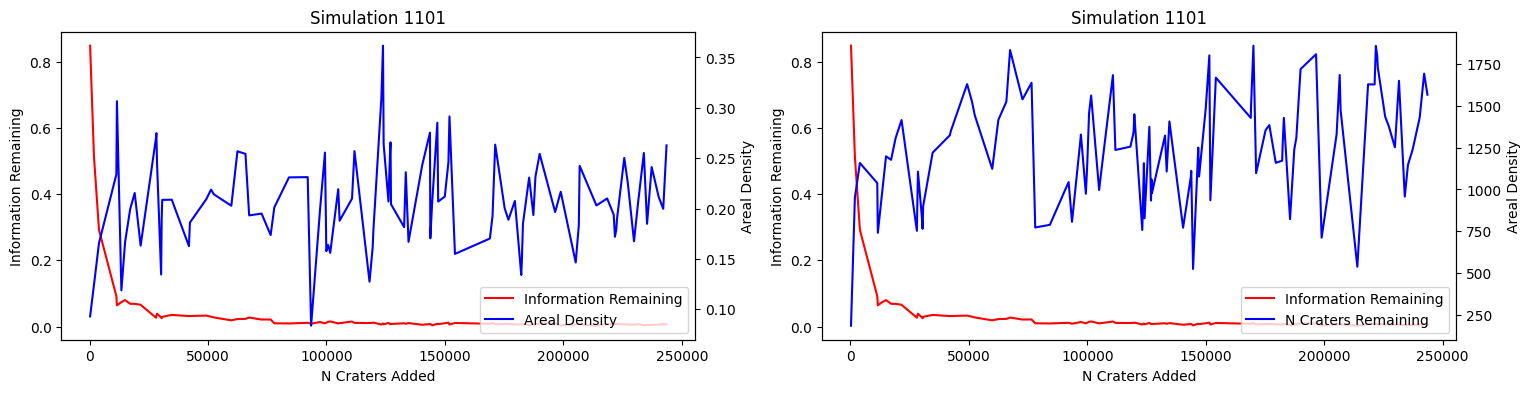

slope                          1.069928
effective_radius_multiplier    1.861670
r_stat_multiplier              5.252428
min_rim_percentage             0.582719
Name: 35871, dtype: float64


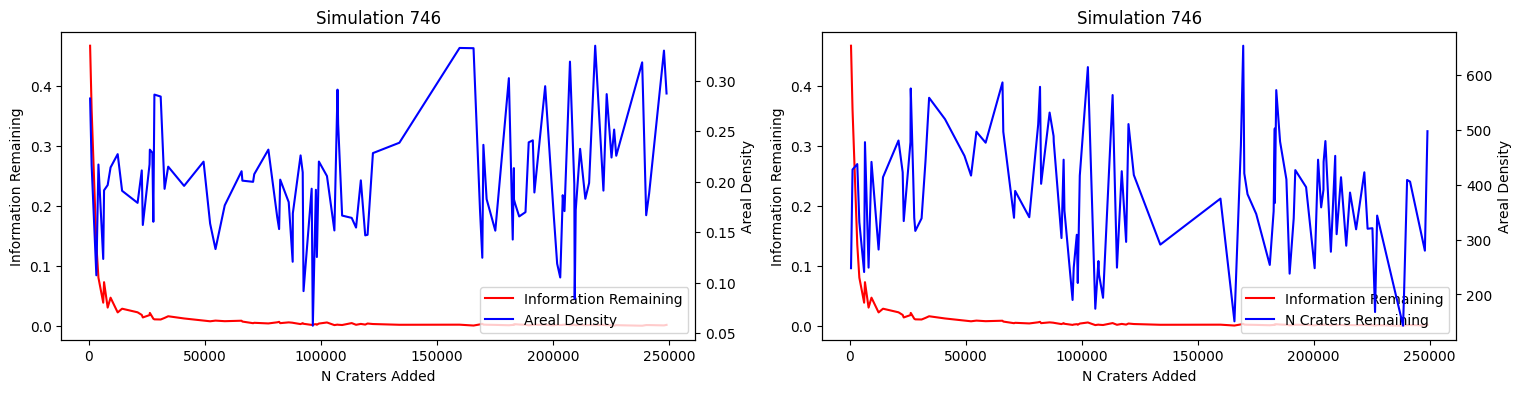

slope                          1.391501
effective_radius_multiplier    1.142613
r_stat_multiplier              3.923293
min_rim_percentage             0.360066
Name: 12633, dtype: float64


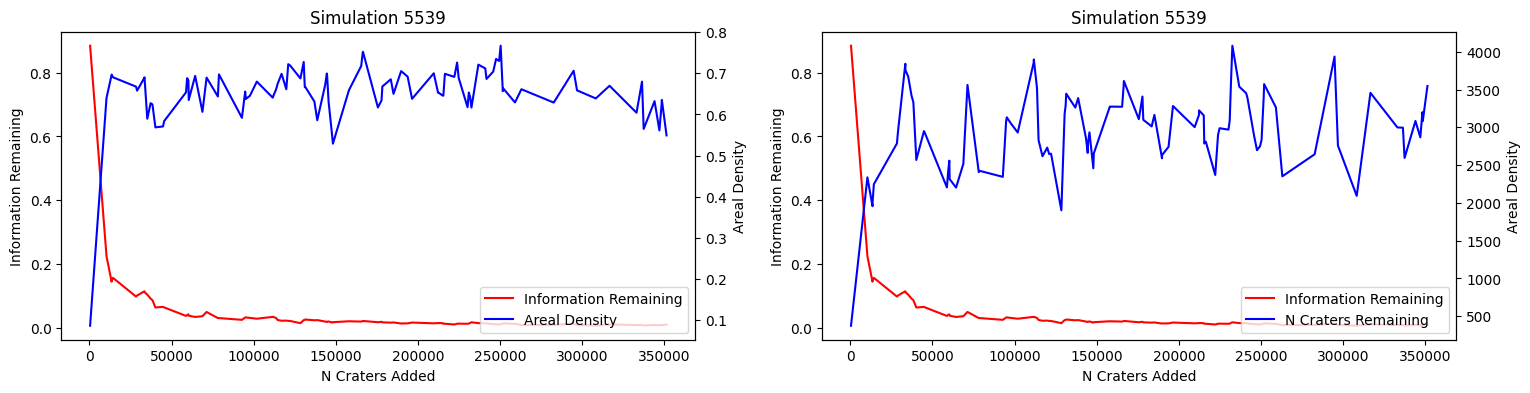

slope                          1.151910
effective_radius_multiplier    1.483210
r_stat_multiplier              8.844950
min_rim_percentage             0.691782
Name: 8145, dtype: float64


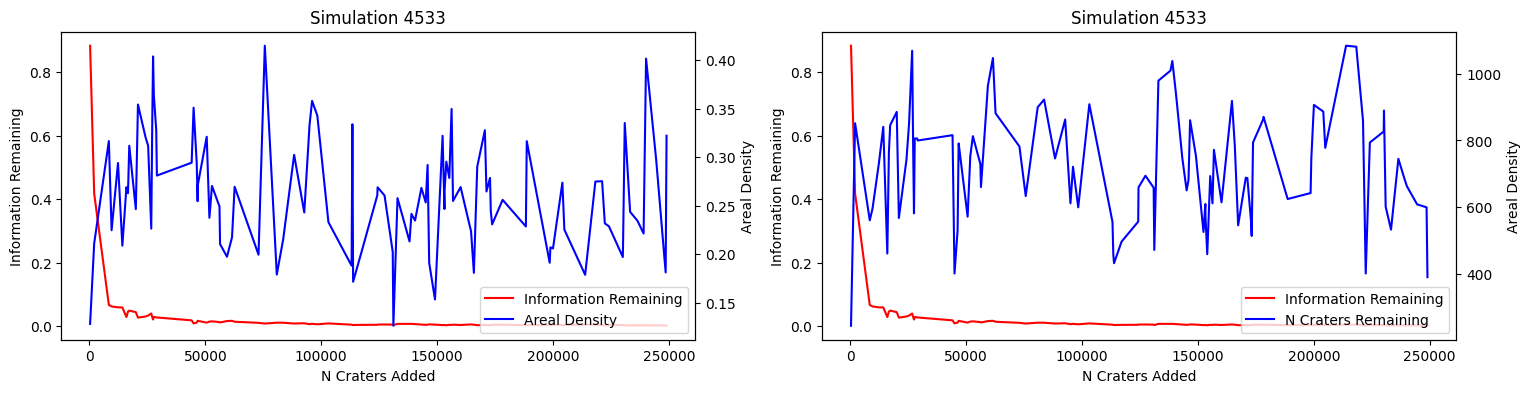

In [6]:
for x in range(8, 15):
    plot_n_ad_and_ir_for_simulation(simulation_ids[x], stats_df)

### Examining Relationships

#### All correlations

<Axes: >

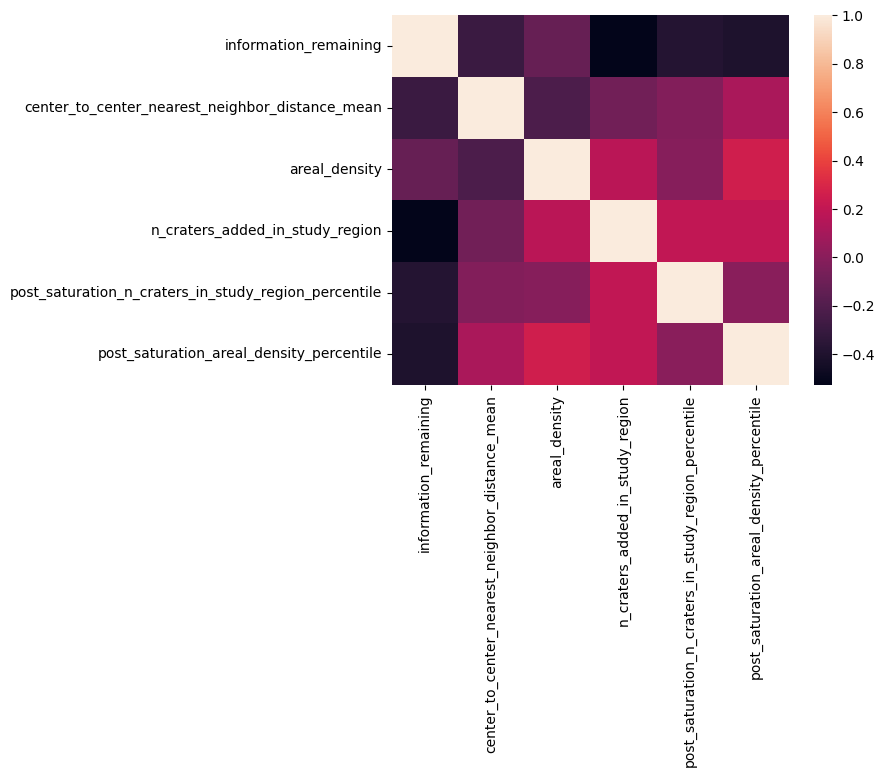

In [12]:
sns.heatmap(stats_df[["information_remaining", "center_to_center_nearest_neighbor_distance_mean", "areal_density", "n_craters_added_in_study_region", "post_saturation_n_craters_in_study_region_percentile", "post_saturation_areal_density_percentile"]].corr())

#### Plots of IVs vs IR

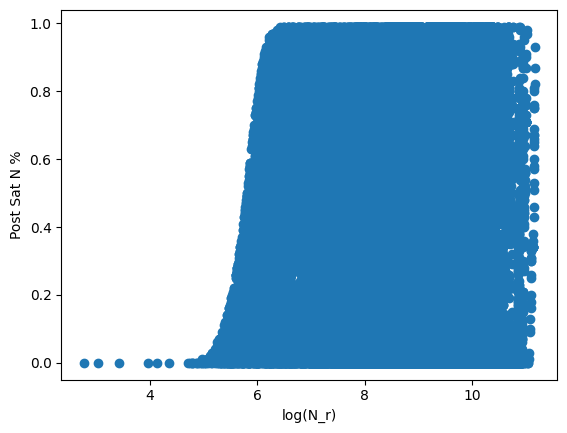

In [16]:
plt.scatter(np.log(stats_df.n_craters_in_study_region), stats_df.post_saturation_n_craters_in_study_region_percentile)
plt.xlabel("log(N_r)")
plt.ylabel("Post Sat N %")
plt.show()

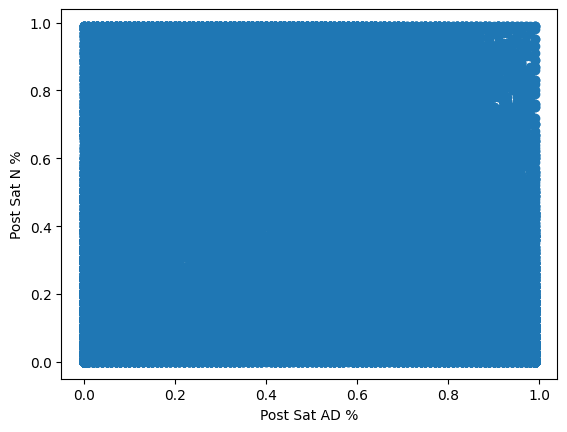

In [18]:
plt.scatter(stats_df.post_saturation_areal_density_percentile, stats_df.post_saturation_n_craters_in_study_region_percentile)
plt.xlabel("Post Sat AD %")
plt.ylabel("Post Sat N %")
plt.show()

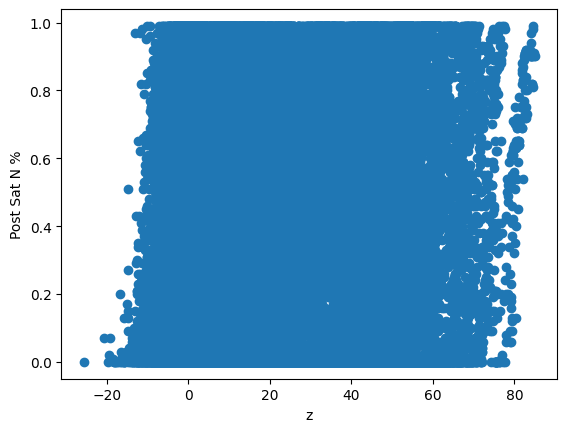

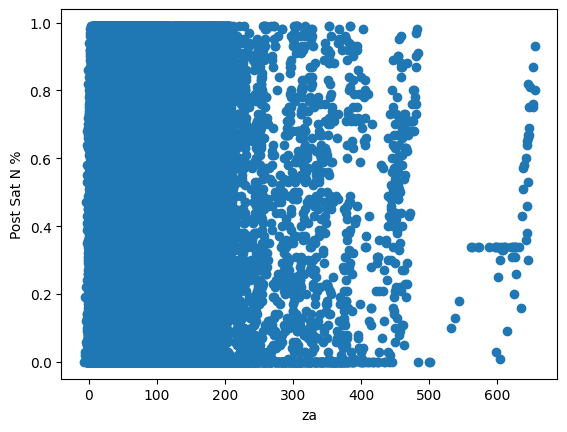

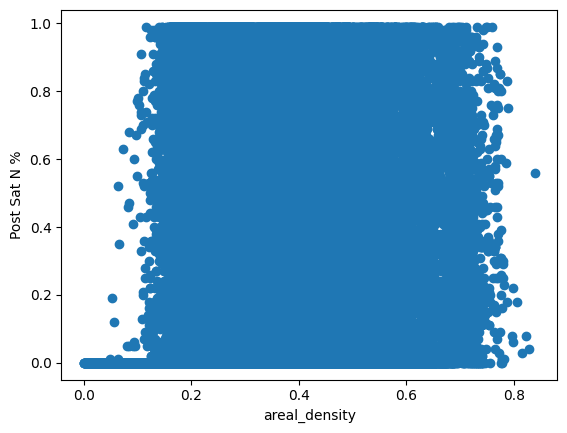

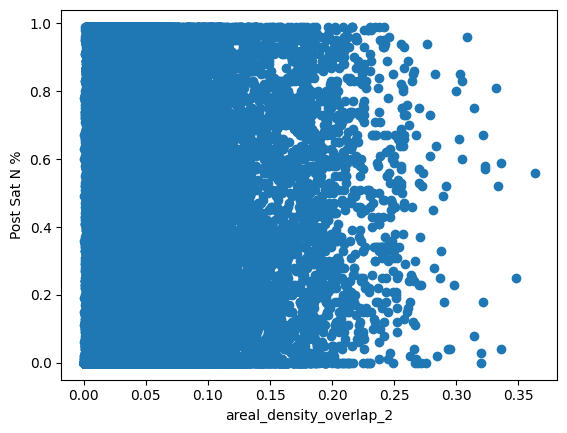

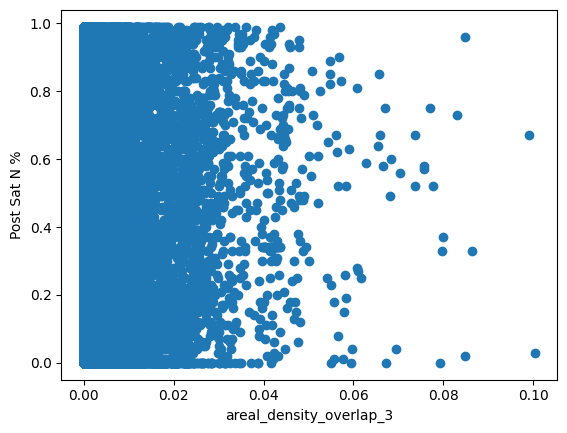

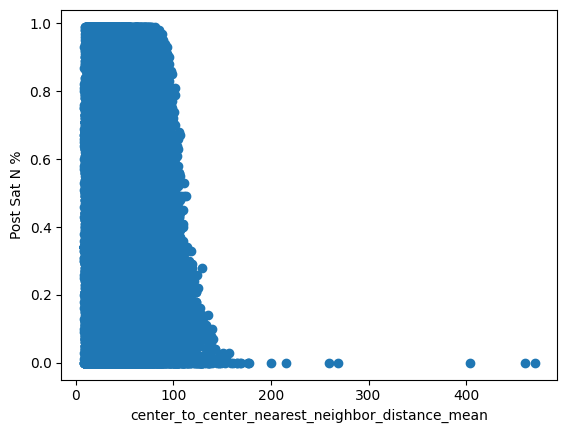

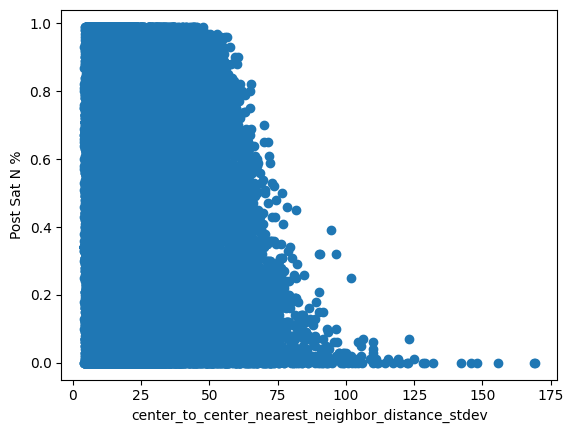

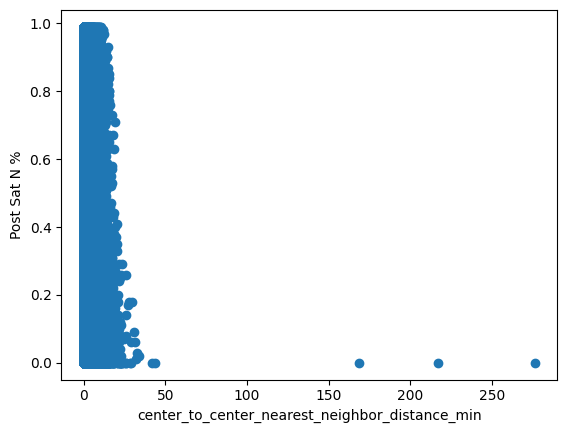

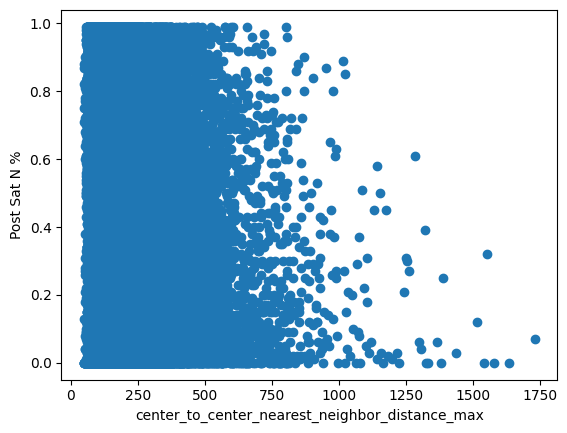

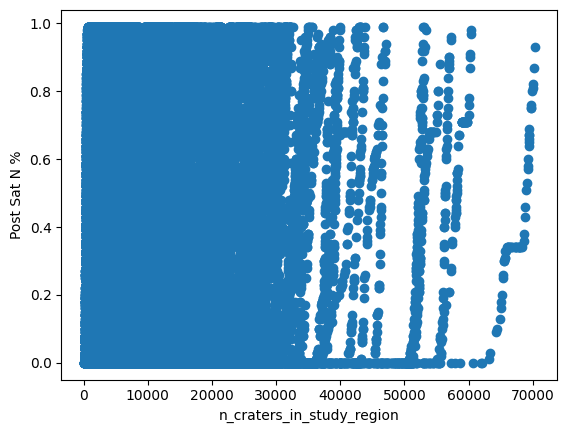

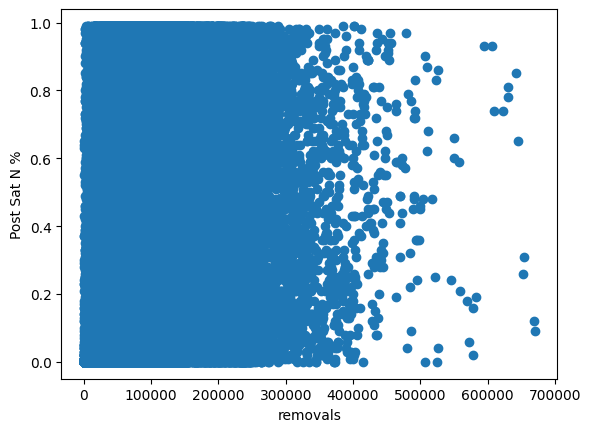

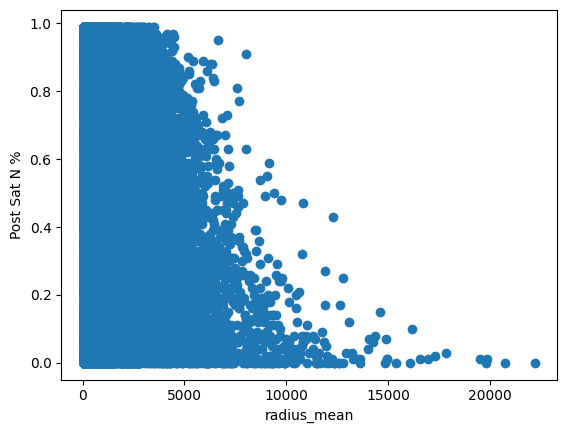

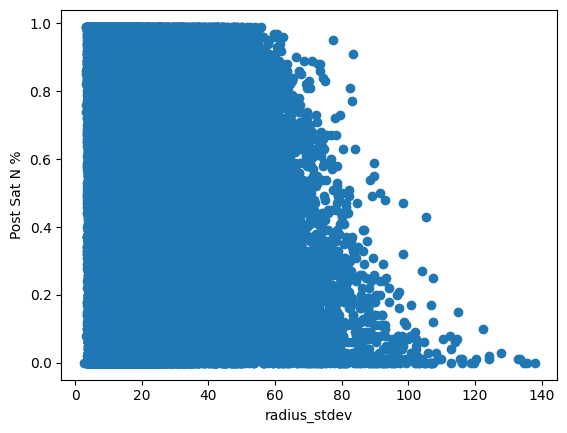

In [17]:
for x in non_constant_ivs:
    plt.scatter(stats_df[x], stats_df.post_saturation_n_craters_in_study_region_percentile)
    plt.xlabel(f"{x}")
    plt.ylabel("Post Sat N %")
    plt.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log



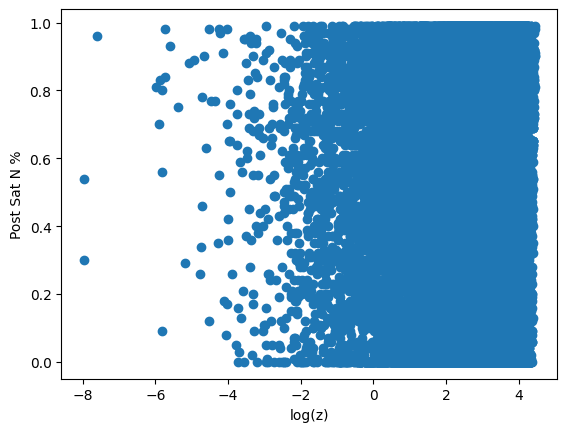

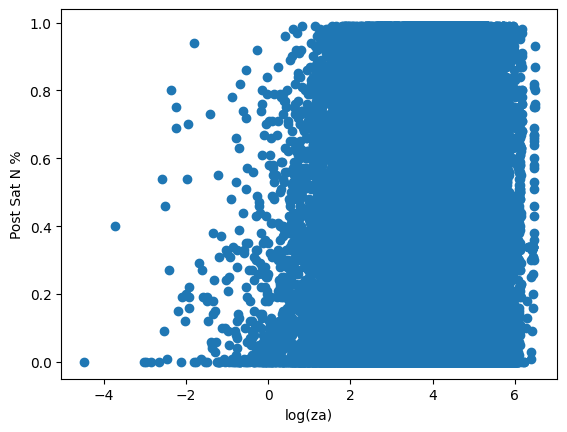

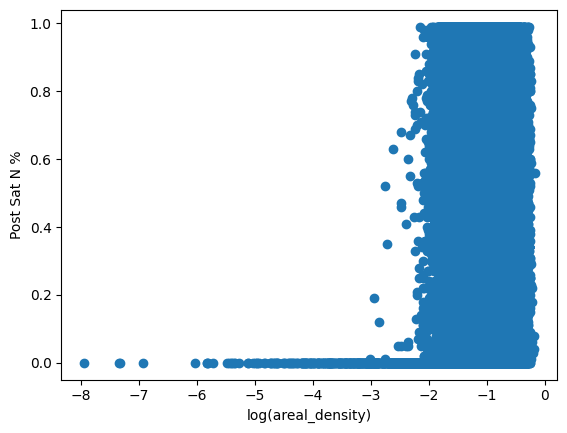

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



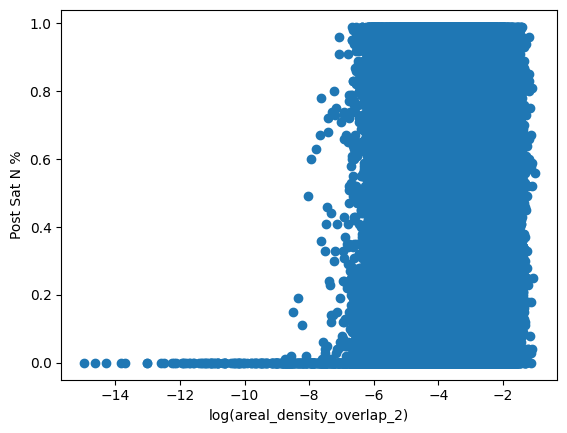

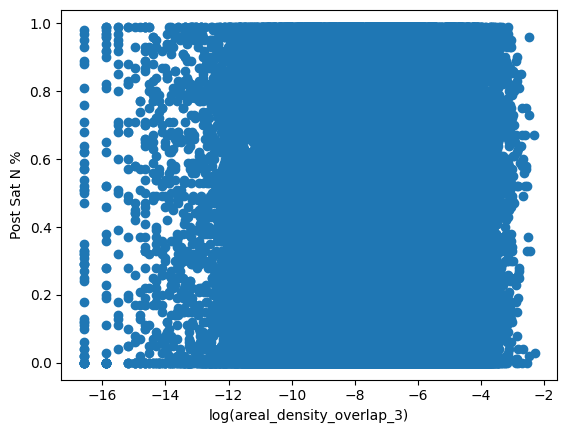

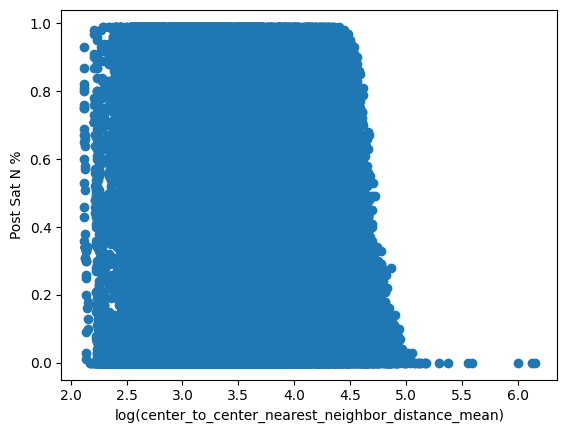

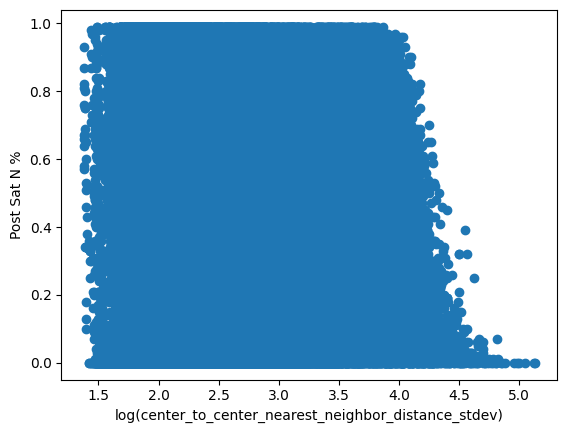

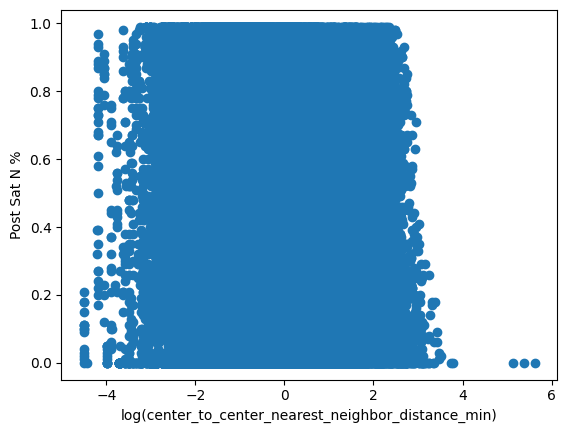

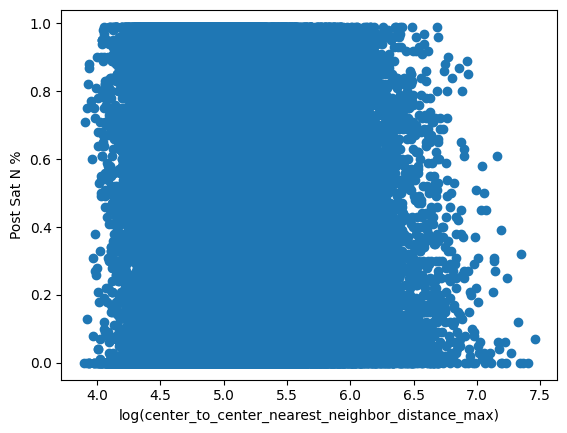

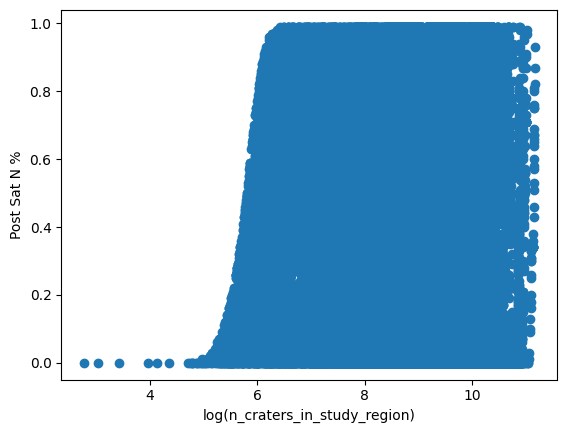

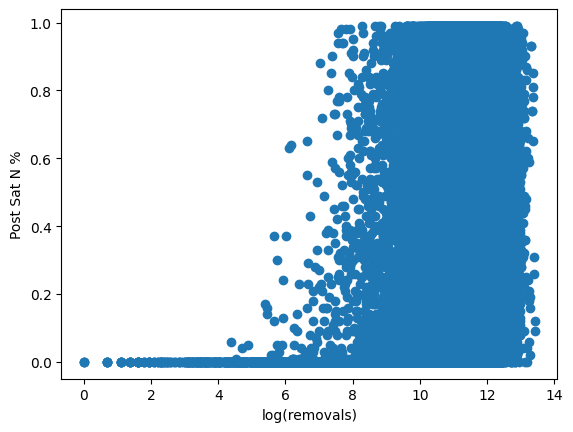

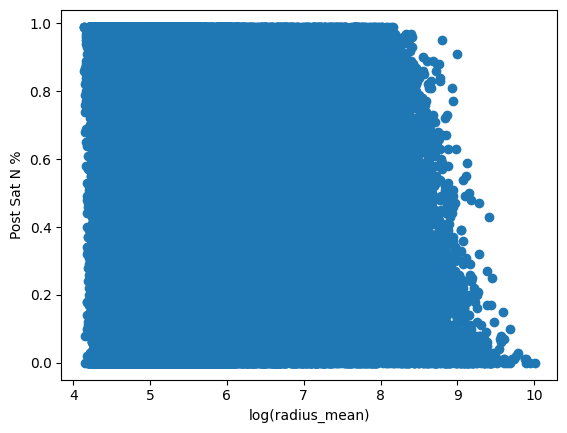

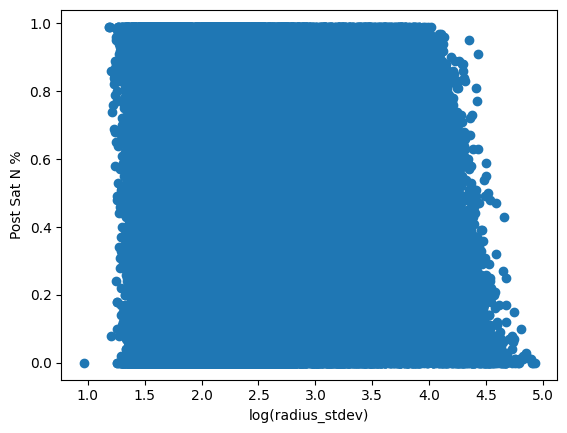

In [19]:
for x in non_constant_ivs:
    plt.scatter(np.log(stats_df[x]), stats_df.post_saturation_n_craters_in_study_region_percentile)
    plt.xlabel(f"log({x})")
    plt.ylabel("Post Sat N %")
    plt.show()

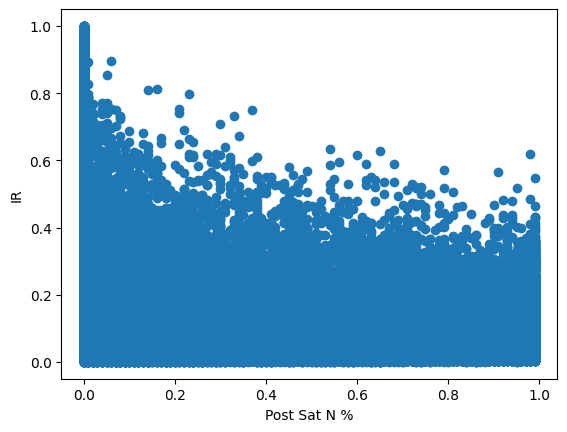

In [22]:
plt.scatter(stats_df.post_saturation_n_craters_in_study_region_percentile, stats_df.information_remaining)
plt.xlabel(f"Post Sat N %")
plt.ylabel("IR")
plt.show()

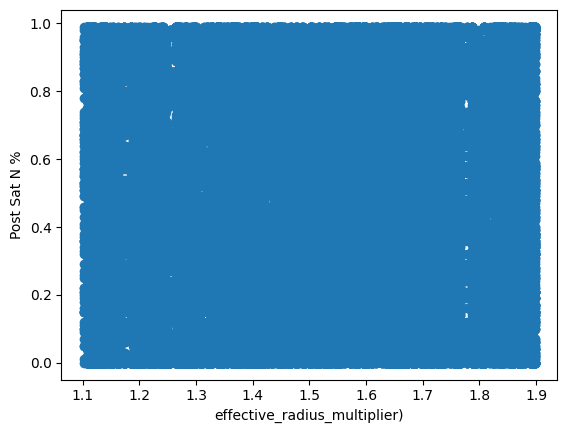

In [23]:
plt.scatter(stats_df.effective_radius_multiplier, stats_df.post_saturation_n_craters_in_study_region_percentile)
plt.xlabel(f"effective_radius_multiplier)")
plt.ylabel("Post Sat N %")
plt.show()

In [27]:
# Failed experiment
df = stats_df
df = df.sample(df.shape[0] // 10).copy()

fig = px.scatter(
    df,
    x="post_saturation_n_craters_in_study_region_percentile",
    y="center_to_center_nearest_neighbor_distance_mean",
    hover_data=ivs + ["removals"],
    size_max=0.25,
    color="slope"
)
fig.show()

# plt.scatter(df.information_remaining, destruction)
# plt.xlabel("IR")
# plt.ylabel("destruction")
# plt.show()

#### Exploratory plots of distance metrics

mean center-to-center nearest neighbor distance showed a peculiar relationship in the previous sections. Let's examine further.

In [28]:
df = stats_df #[stats_df.information_remaining < 0.5].copy()
# df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_removals"] = np.log10(1 + df.removals)
df["log_areal_density"] = np.log10(df.areal_density)
df["color"] = df.min_rim_percentage * df.effective_radius_multiplier

fig = px.scatter(
    df,
    x="post_saturation_n_craters_in_study_region_percentile",
    y="areal_density",
    hover_data=ivs + ["removals", "information_remaining"],
    size_max=0.25,
    color="slope"
)
fig.show()

In [29]:
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
df["log_za"] = np.log10(df.za)

df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["e_slope"] = np.exp(df.slope)

df["color"] = df.min_rim_percentage * df.effective_radius_multiplier

fig = px.scatter(
    df,
    y="post_saturation_n_craters_in_study_region_percentile",
    x="log_center_to_center_nearest_neighbor_distance_mean",
    hover_data=ivs + ["removals"],
    size_max=1,
    color="slope",
)
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log10



In [45]:
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
df["log_n_craters_in_study_region"] = np.log10(df.n_craters_in_study_region)


fig = px.scatter_3d(
    df,
    x="effective_radius_multiplier",
    y="slope",
    z="log_n_craters_in_study_region",
    hover_data=ivs + ["removals"],
    size_max=1,
    color="post_saturation_n_craters_in_study_region_percentile",
    width=1600,
    height=800
)
fig.update_traces(marker={"size":3})
fig.show()